# Fit the optical spectrum of Type 1 AGN (SDSS J094310.12+604559.1)
* Check [astropy.modelling](https://docs.astropy.org/en/latest/modeling/index.html) for more introduction
* SAGAN adopts the frame work of astropy.modelling
* Modified by Guodong and edited on 2025-06-14

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astroquery.sdss import SDSS
from astropy import coordinates as coords
import astropy.units as u
from astropy.time import Time

from astropy.modeling import models, fitting
import sys
sys.path.append('../../SAGAN-Modified/')
import sagan


import matplotlib as mpl
mpl.rc("xtick", direction="in", labelsize=16)
mpl.rc("ytick", direction="in", labelsize=16)
mpl.rc("xtick.major", width=1., size=8)
mpl.rc("ytick.major", width=1., size=8)
mpl.rc("xtick.minor", width=1., size=5)
mpl.rc("ytick.minor", width=1., size=5)

# automatic reload the modules
%load_ext autoreload
%autoreload 2

# Find the Spectrum from the SDSS archive
* Check [astroquery.sdss](https://astroquery.readthedocs.io/en/latest/sdss/sdss.html) for more introduction

Text(0.5, 1.0, 'SDSS J082912.67+500652.3')

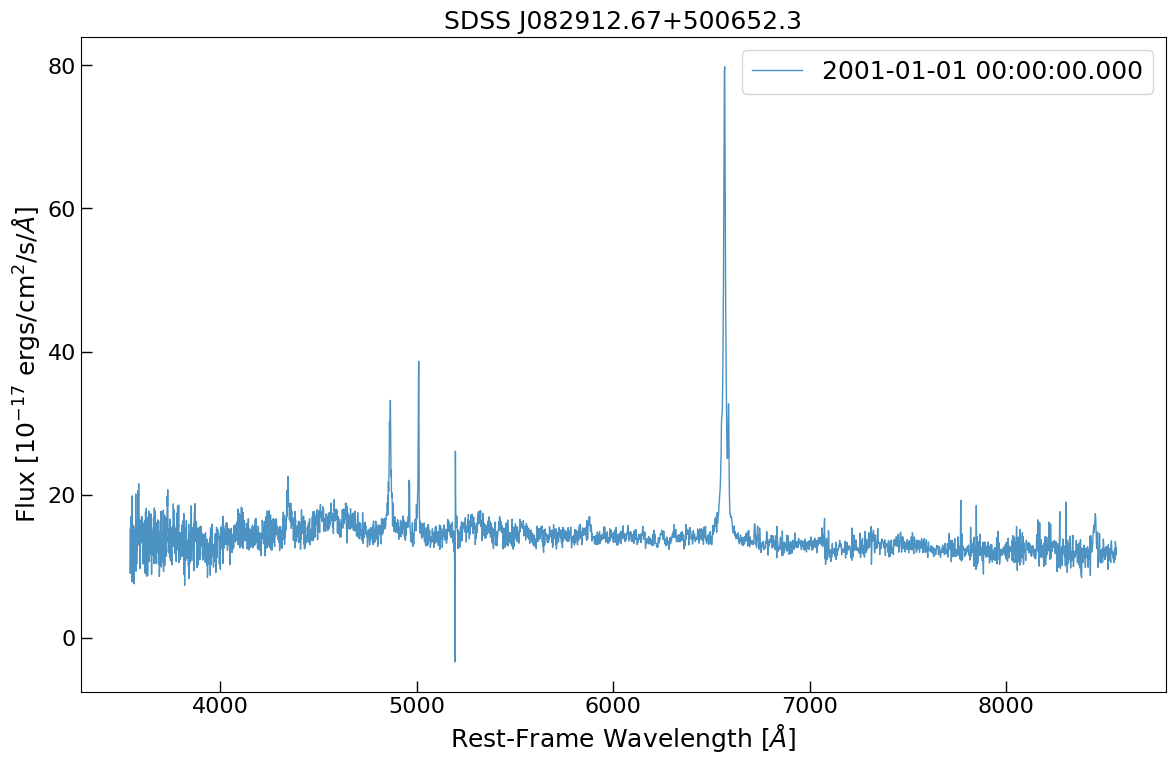

In [2]:
#Find the spectrum
name='J094310.12+604559.1'
pos = coords.SkyCoord('09h43m10.12s +60d45m59.1s', frame='icrs')
xid = SDSS.query_region(pos, spectro=True,radius=5*u.arcsec)
sp = SDSS.get_spectra(matches=xid)

fig, ax = plt.subplots(figsize=(14.,8.5))
for i in np.arange(xid['ra'].size):
    hdr=sp[i][0].header
    t   =Time(float(hdr['MJD']),format='mjd')
    t.format='iso'
    ax.plot((10.**sp[i][1].data['loglam'])/(1+sp[i][2].data['z'][0]),sp[i][1].data['flux'],label=t.value,linewidth=1,alpha=0.8)
ax.set_ylabel(r'Flux [10$^{-17}$ ergs/cm$^2$/s/$\AA$]',fontsize=18)
ax.set_xlabel('Rest-Frame Wavelength [$\AA$]',fontsize=18)
ax.legend(loc='upper right',fontsize=18)
ax.set_title('SDSS J082912.67+500652.3',fontsize=18)

### Read data and correct the Milky Way extinction
* Check [here](https://github.com/kbarbary/sfddata) for dust map
* Check [here](https://github.com/sczesla/PyAstronomy/tree/master) for the dust correction

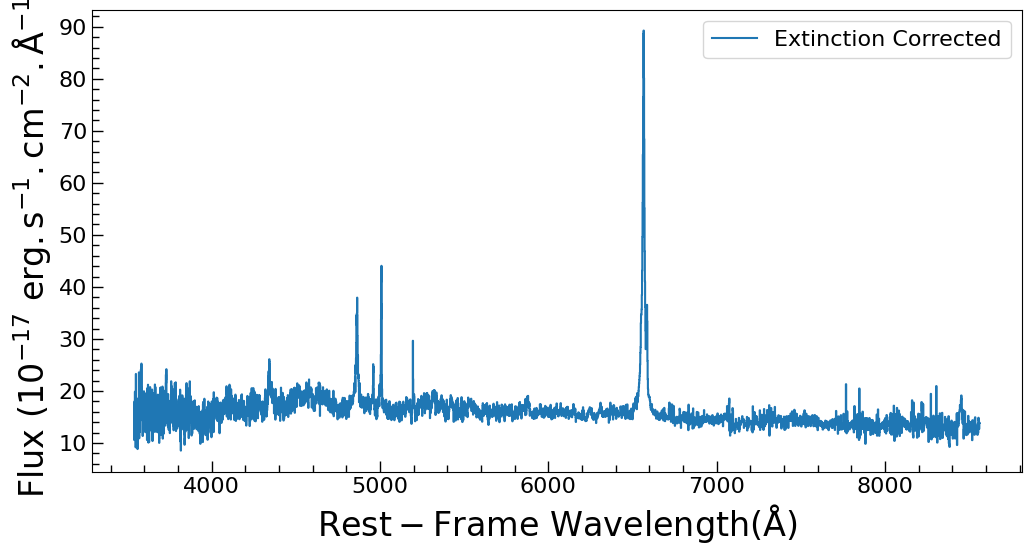

In [3]:
#Select the first spectrum and make the dust correction from the Milky Way (Schlegel, Finkbeiner and Davis 1998)
hdu = sp[0]
lam_res_unred, flux_res_unred, err_unred = sagan.ReadSpectrum(is_sdss=True, hdu=hdu).unredden_res()

fig, ax = plt.subplots(figsize=(12, 6))
ax.step(lam_res_unred, flux_res_unred, label='Extinction Corrected', c='C0')
#ax.set_yscale('log')
ax.set_xlabel(r'$\rm {Rest-Frame \ Wavelength (\AA)}$',fontsize=24)
ax.set_ylabel(r'$\rm {Flux \ (10^{-17} \ erg.s^{-1}.cm^{-2}.{\AA}^{-1})}$',fontsize=24)
ax.legend(fontsize=16)
ax.minorticks_on()
plt.show()

### Cut the useful data
* First move to the rest frame
* Cut the wavelength range following Kuhn et al. (2024)

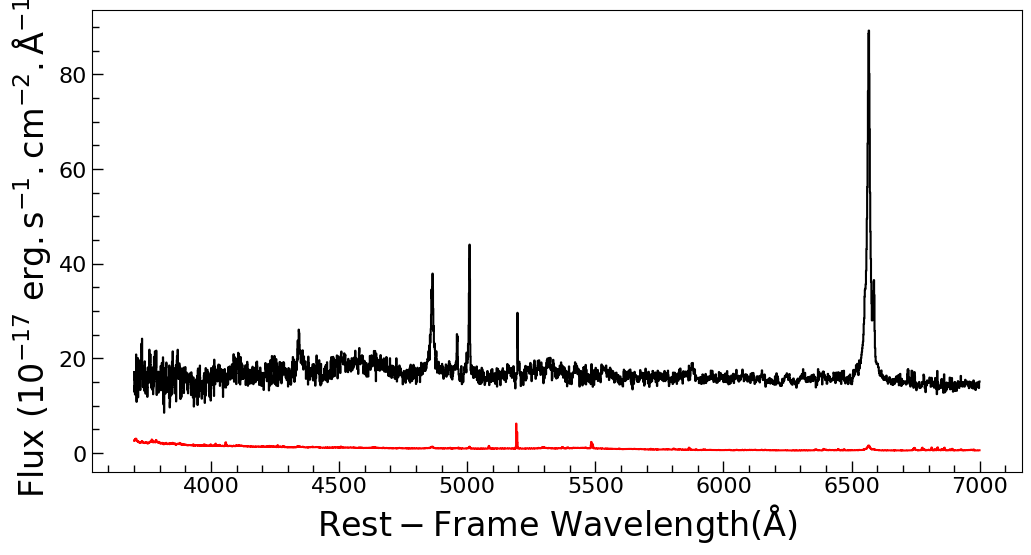

In [4]:
fig, ax = plt.subplots(figsize=(12, 6))
wmin, wmax = 3700, 7000
fltr = (lam_res_unred > wmin) & (lam_res_unred < wmax)
wave_use = lam_res_unred[fltr]
flux_use = flux_res_unred[fltr]
ferr = err_unred[fltr]

ax.step(wave_use, flux_use, color='k')
ax.step(wave_use, ferr, color='r')
ax.set_xlabel(r'$\rm {Rest-Frame \ Wavelength (\AA)}$',fontsize=24)
#ax.set_ylabel(r'$F_\lambda\:(\mathrm{erg\,s^{-1}\,cm^{-2}\,\lambda^{-1}})$', fontsize=24)
ax.set_ylabel(r'$\rm {Flux \ (10^{-17} \ erg.s^{-1}.cm^{-2}.{\AA}^{-1})}$',fontsize=24)
ax.minorticks_on()
plt.show()

### Fit spectrum
* Check the emission lines here: http://astronomy.nmsu.edu/drewski/tableofemissionlines.html
* Tie all the narrow lines to [S II] $\lambda\lambda$ 6718,6733 doublet
* Iterate many times until you find a good result
* * The continuum will be fitted using the FeII + PL + Star (A, F, G, K, M) model to a specified spectral window.
* * Fitting [S II] line and using it as narrow line template, fixing the shape of the continuum and optionally fitting its amplitude
* * Fitting other lines, using narrow line template ([S II]) and fixing the shape of the continuum and optionally fitting its amplitude

100%|█████████████████████████████████████| 10000/10000 [03:41<00:00, 45.19it/s]


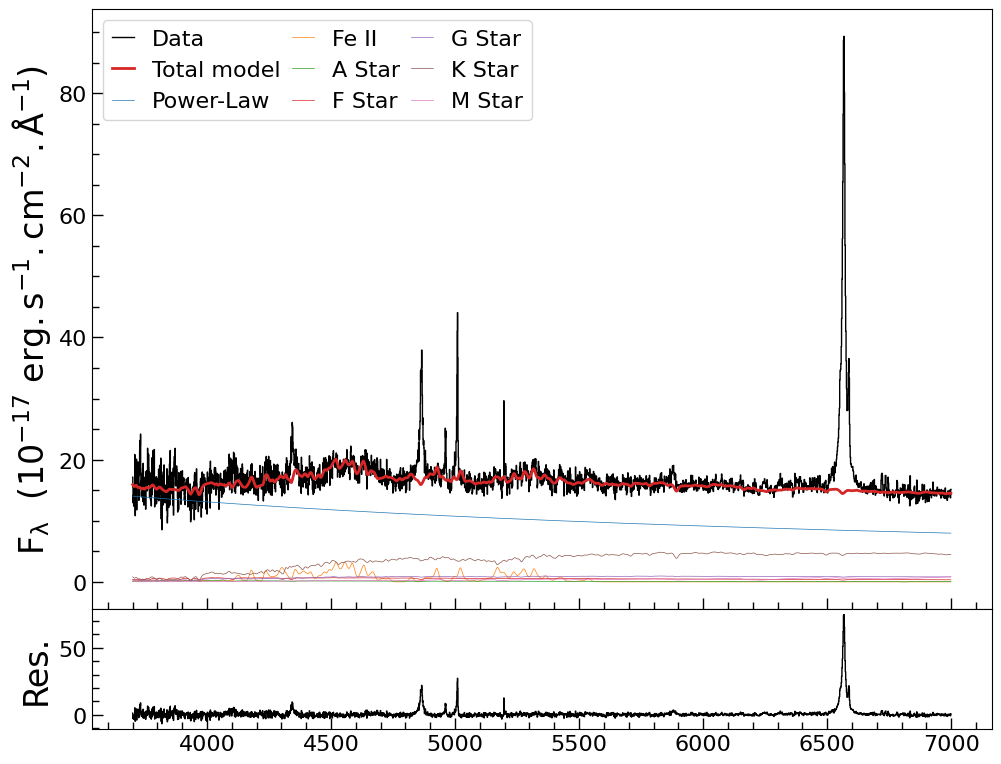

In [13]:
#fit the continuum
#cont_window_lo = [4110, 4400, 4500, 4750, 5050, 5230]
#cont_window_up = [4320, 4450, 4650, 4800, 5150, 5400]
cont_window_lo = [3700, 3740, 4041, 4170, 4430, 5080, 6050, 6400, 6890]
cont_window_up = [3715, 3800, 4043, 4260, 4770, 5550, 6200, 6450, 7010]
ins = np.zeros_like(wave_use, dtype=bool)
for i in range(len(cont_window_up)):
    ins |= (wave_use > cont_window_lo[i]) & (wave_use < cont_window_up[i])
cont_x = wave_use[ins]
cont_y = flux_use[ins]
cont_y_e = ferr[ins]
weights = 1/ferr**2
pl = models.PowerLaw1D(amplitude=0.55, x_0=5500, alpha=1.0, fixed={'x_0': True}, name='Power-Law')
iron = sagan.IronTemplate(amplitude=0.2, stddev=1000, z=0, name='Fe II')
iron.z.fixed = True
Star_A = sagan.StarSpectrum(amplitude=0.2, sigma=10, velscale=50, Star_type='A', name='A Star',
                            bounds={'sigma':(3, 500)})
Star_F = sagan.StarSpectrum(amplitude=0.2, sigma=10, velscale=50, Star_type='F', name='F Star')
Star_G = sagan.StarSpectrum(amplitude=0.2, sigma=10, velscale=50, Star_type='G', name='G Star')
Star_K = sagan.StarSpectrum(amplitude=0.2, sigma=10, velscale=50, Star_type='K', name='K Star')
Star_M = sagan.StarSpectrum(amplitude=0.2, sigma=10, velscale=50, Star_type='M', name='M Star')
    
m_init = pl + iron + Star_A + Star_F + Star_G + Star_K + Star_M
def tie_v(model):
    return model['A Star'].sigma

for tem in [Star_F, Star_G, Star_K, Star_M]:
    tem.sigma.tied = tie_v

mcmc = sagan.MCMC_Fit(m_init,cont_x, cont_y, cont_y_e, nwalkers=50, nsteps=10000)
samples,  m_fit_cont, param_names = mcmc.fit()
ax, axr = sagan.plot.plot_fit(wave_use, flux_use, m_fit_cont, weight=weights)
ax.set_ylabel(r'$\rm {F_\lambda\ \ (10^{-17} \ erg.s^{-1}.cm^{-2}.{\AA}^{-1})}$', fontsize=24)
plt.show()


100%|████████████████████████████████████| 10000/10000 [00:41<00:00, 240.85it/s]


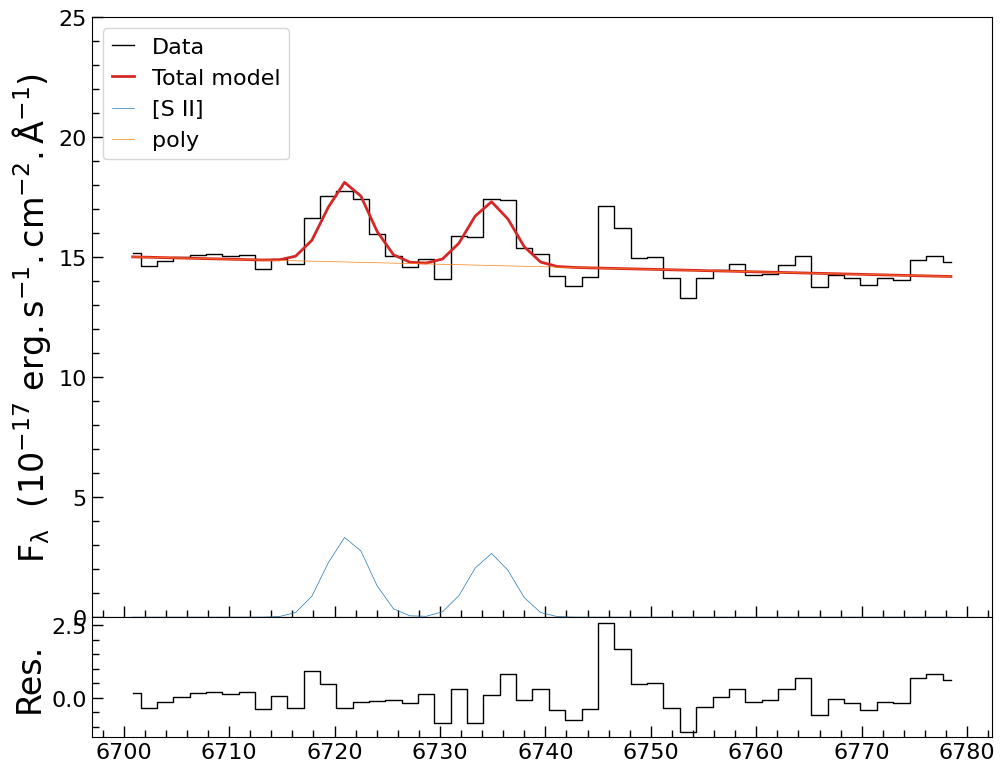

amp_c0_0: 3.347710623703601
amp_c1_0: 2.6561949112474466
dv_c_0: 157.3083249227332
sigma_c_0: 91.65088827979035
c0_1: 85.62107506526242
c1_1: -0.010537469546792426


In [7]:
ins = (wave_use>6700)&(wave_use<6780)

wave_dict = sagan.utils.line_wave_dict
label_dict = sagan.utils.line_label_dict
bounds = {'sigma_c':(20,100), 'dv_c':(-10, 1000), 'amp_c0':(2, 300)}
line_s2 = sagan.Line_MultiGauss_doublet(n_components=1, amp_c0=20, amp_c1=20, sigma_c=60, dv_c=100,
                                        wavec0=wave_dict['SII_6718'], wavec1=wave_dict['SII_6733'], name='[S II]', bounds=bounds)
poly = models.Polynomial1D(degree=1, name='poly')
m_init  = line_s2+poly
weights = 1/ferr**2

#Least squares fitting
#fitter = fitting.TRFLSQFitter(calc_uncertainties=True)
#m_fit_SII = fitter(m_init, wave_use[ins], flux_use[ins], weights=weights[ins], maxiter=20000, filter_non_finite=True, estimate_jacobian=True)

mcmc = sagan.MCMC_Fit(m_init,wave_use[ins], flux_use[ins], ferr[ins], nwalkers=50, nsteps=10000)
samples,  m_fit_SII, param_names = mcmc.fit()

ax, axr = sagan.plot.plot_fit(wave_use[ins], flux_use[ins], m_fit_SII, weight=weights[ins])
ax.set_ylabel(r'$\rm {F_\lambda\ \ (10^{-17} \ erg.s^{-1}.cm^{-2}.{\AA}^{-1})}$', fontsize=24)
ax.set_ylim(0,25)
plt.show()

param_names = sagan.get_free_params(m_fit_SII)

for param_name in param_names:
    param_value = getattr(m_fit_SII, param_name).value 
    print(f'{param_name}: {param_value}')


100%|████████████████████████████████████| 10000/10000 [01:03<00:00, 157.97it/s]


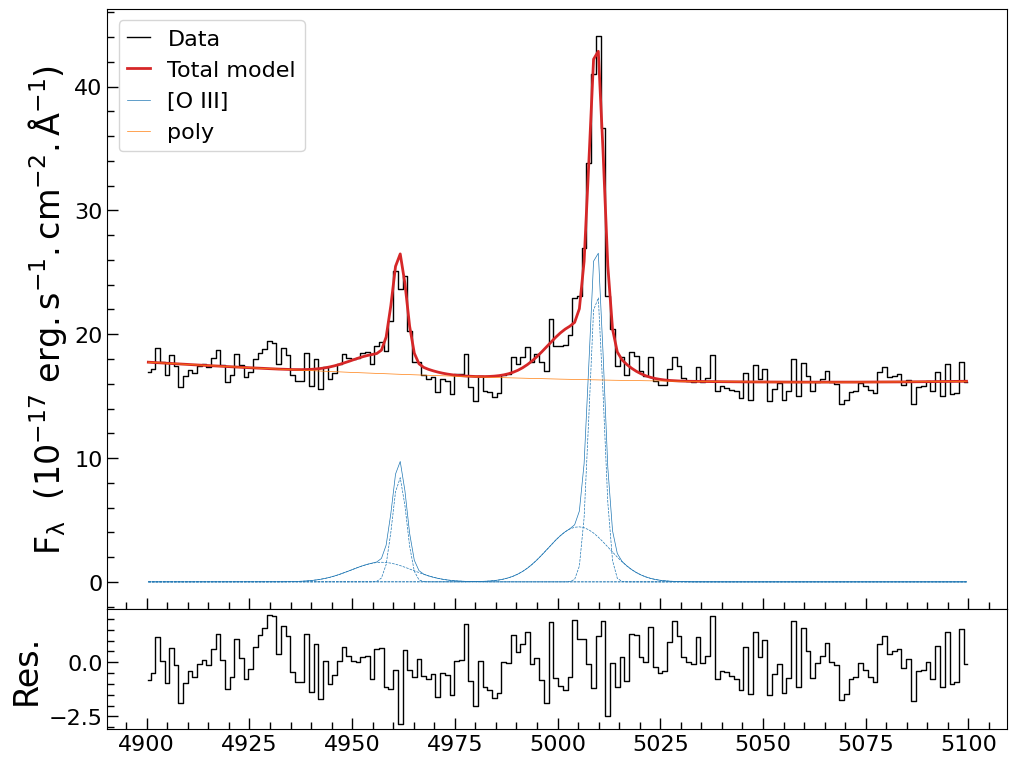

amp_c0_0: 23.800201629301004
dv_c_0: 156.2571690762593
sigma_c_0: 102.60221058235857
amp_w0_0: 0.18682249745646
dv_w0_0: -260.56217740292595
sigma_w0_0: 447.0029412483076
c0_1: 1549.6842224740067
c1_1: -0.6055934821194437
c2_1: 5.978650613150101e-05


In [9]:
ins = (wave_use>4900)&(wave_use<5100)

wave_dict = sagan.utils.line_wave_dict
label_dict = sagan.utils.line_label_dict
line_o3 = sagan.Line_MultiGauss_doublet(n_components=2, amp_c0=20, amp_c1=20, dv_c=-43, sigma_c=150,
                                        amp_w0=0.3, dv_w0=-43, sigma_w0=500,
                                        wavec0=wave_dict['OIII_5007'], wavec1=wave_dict['OIII_4959'], name='[O III]')

def tie_o3(model):
    return model['[O III]'].amp_c0 / 2.98
line_o3.amp_c1.tied = tie_o3

poly = models.Polynomial1D(degree=2, name='poly')

m_init  = line_o3+poly
weights = 1/ferr**2

#fitter = fitting.TRFLSQFitter(calc_uncertainties=True)
#m_fit_OIII = fitter(m_init, wave_use[ins], flux_use[ins], weights=weights[ins], maxiter=20000, filter_non_finite=True, estimate_jacobian=True)
#param_names = get_free_params(m_fit_OIII)
#param_values = fitter.fit_info['x']
#param_cov = fitter.fit_info['param_cov']
#if param_cov is not None:
#    param_errors = np.sqrt(np.diag(param_cov))
#    for name, value, error in zip(param_names, param_values, param_errors):
#        print(f"{name} = {value:.4f}, error: {error:.4f}")`

mcmc = sagan.MCMC_Fit(m_init,wave_use[ins], flux_use[ins], ferr[ins], nwalkers=50, nsteps=10000)
samples,  m_fit_OIII, param_names = mcmc.fit()

ax, axr = sagan.plot.plot_fit(wave_use[ins], flux_use[ins], m_fit_OIII, weight=weights[ins])
ax.set_ylabel(r'$\rm {F_\lambda\ \ (10^{-17} \ erg.s^{-1}.cm^{-2}.{\AA}^{-1})}$', fontsize=24)
plt.show()

param_names = sagan.get_free_params(m_fit_OIII)

for param_name in param_names:
    param_value = getattr(m_fit_OIII, param_name).value 
    print(f'{param_name}: {param_value}')


### Create a narrow line template using [S II]6716 and [O III]5007

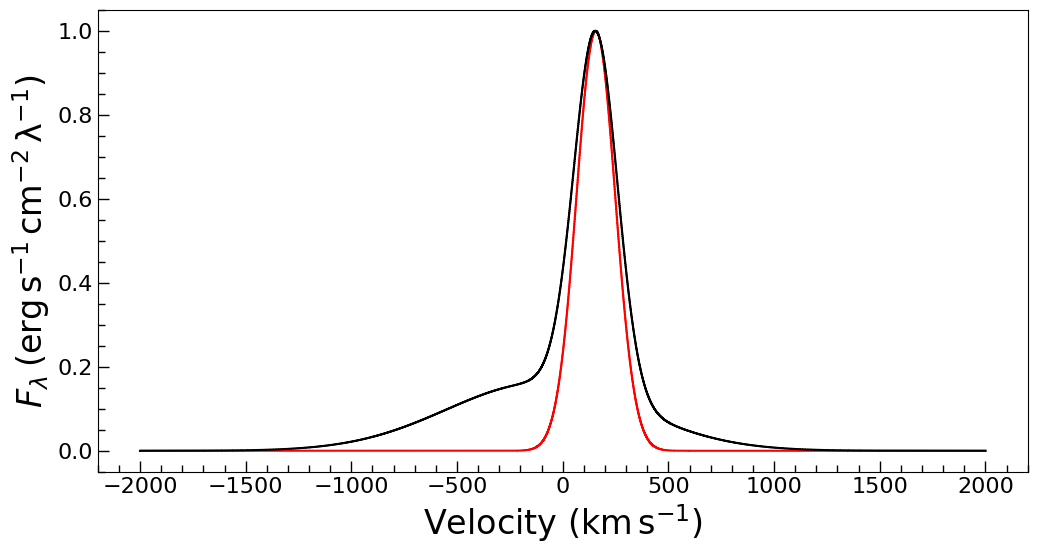

In [10]:
velc_SII_tmpl = np.linspace(-2000, 2000, 4000)
flux_SII_tmpl = m_fit_SII['[S II]'].gen_template(velc_SII_tmpl, normalized=True)

velc_OIII_tmpl = np.linspace(-2000, 2000, 4000)
flux_OIII_tmpl = m_fit_OIII['[O III]'].gen_template(velc_OIII_tmpl, normalized=True)

fig, ax = plt.subplots(figsize=(12, 6))
ax.step(velc_SII_tmpl, flux_SII_tmpl, color='r')
ax.step(velc_OIII_tmpl, flux_OIII_tmpl, color='k')
ax.set_xlabel(r'Velocity ($\mathrm{km\,s^{-1}}$)', fontsize=24)
ax.set_ylabel(r'$F_\lambda\:(\mathrm{erg\,s^{-1}\,cm^{-2}\,\lambda^{-1}})$', fontsize=24)
ax.minorticks_on()
plt.show()

100%|█████████████████████████████████████| 15000/15000 [03:50<00:00, 65.12it/s]


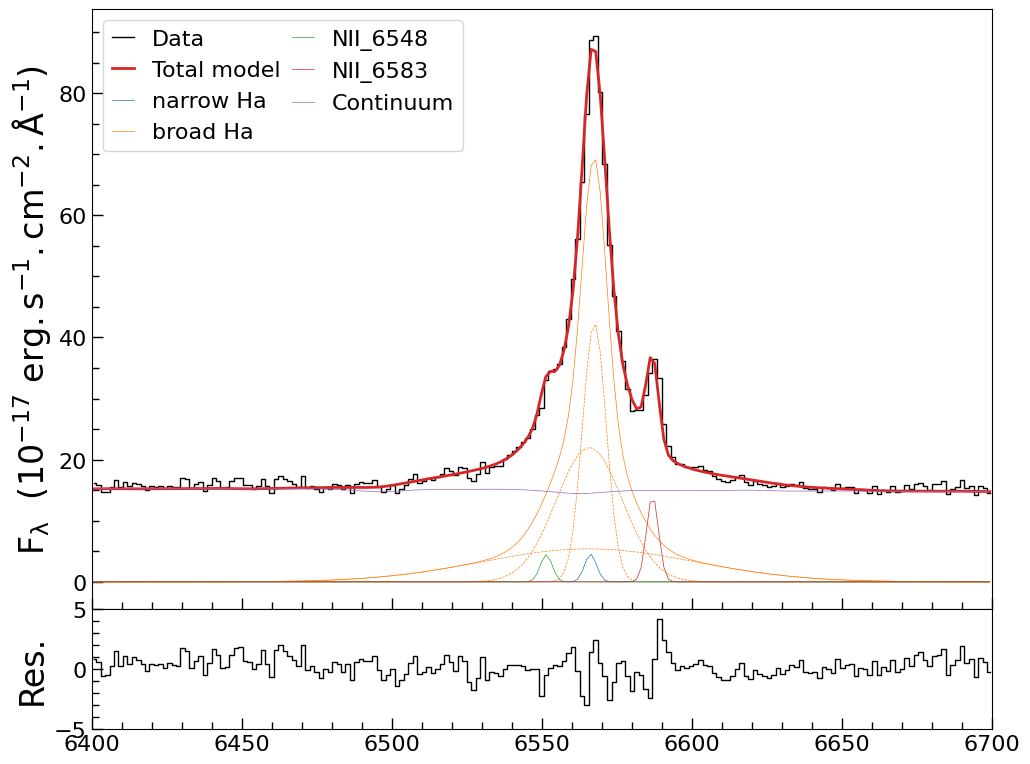

amplitude_0: 4.535590124462398
amp_c_1: 5.401152833581093
dv_c_1: 124.00413822318237
sigma_c_1: 1629.3121680161503
amp_w0_1: 4.0678544415838855
dv_w0_1: 14.106052546638448
sigma_w0_1: 505.3494875287112
amp_w1_1: 7.843844683836037
dv_w1_1: 91.67841787972077
sigma_w1_1: 180.74953346389225
amplitude_3: 14.085827796895


In [15]:
def m_init_Ha(velc_tmpl, flux_tmpl, m_fit_cont):
    wave_dict = sagan.utils.line_wave_dict
    label_dict = sagan.utils.line_label_dict
    n_ha = sagan.Line_template(template_velc=velc_tmpl, template_flux=flux_tmpl, 
                               dv=0, amplitude=50, wavec=wave_dict['Halpha'], name=f'narrow Ha',fixed={'dv': True})
    n_NII_1 = sagan.Line_template(template_velc=velc_tmpl, template_flux=flux_tmpl, 
                                  dv=0, amplitude=3, wavec=wave_dict['NII_6548'], name=f'NII_6548',fixed={'dv': True})
    n_NII_2 = sagan.Line_template(template_velc=velc_tmpl, template_flux=flux_tmpl, 
                                  dv=0, amplitude=3, wavec=wave_dict['NII_6583'], name=f'NII_6583',fixed={'dv': True})
    b_ha = sagan.Line_MultiGauss(n_components=3, amp_c=10, dv_c=280, sigma_c=1000, 
                                 wavec=wave_dict['Halpha'],
                                 amp_w0=0.5, dv_w0=0, sigma_w0=500,
                                 amp_w1=0.5, dv_w1=0, sigma_w1=50,
                                 name=f'broad Ha', fixed={'wavec': True}, bounds={'sigma_c':(30, 2000), 'sigma_w0':(50, 2000),'sigma_w1':(30, 500),}
                                 )
    def tie_n2(model):
        return model['NII_6583'].amplitude / 2.96
    n_NII_1.amplitude.tied = tie_n2
    
    def m_fit_cont_func(x):
        return m_fit_cont(x)
    cont = sagan.TierContinuum(y_func=m_fit_cont_func, amplitude=1.0, name=f'Continuum')
    cont.amplitude.fixed = True
    
    line_ha = n_ha+b_ha
    line_NII = n_NII_1+n_NII_2
    m_init = line_ha+line_NII+cont
    return m_init

ins = ((wave_use>6400)&(wave_use<6700))
weights = 1/ferr**2
m_init = m_init_Ha(velc_SII_tmpl, flux_SII_tmpl, m_fit_cont)

mcmc = sagan.MCMC_Fit(m_init,wave_use[ins], flux_use[ins], ferr[ins], nwalkers=70, nsteps=15000)
samples,  m_fit_Ha, param_names = mcmc.fit()

ax, axr = sagan.plot.plot_fit(wave_use[ins], flux_use[ins], m_fit_Ha, weight=weights[ins])
ax.set_xlim(6400,6700)
axr.set_ylim(-5, 5)
ax.set_ylabel(r'$\rm {F_\lambda\ \ (10^{-17} \ erg.s^{-1}.cm^{-2}.{\AA}^{-1})}$', fontsize=24)
plt.show()

param_names = sagan.get_free_params(m_fit_Ha)

for param_name in param_names:
    param_value = getattr(m_fit_Ha, param_name).value 
    print(f'{param_name}: {param_value}')



#fitter = fitting.TRFLSQFitter(calc_uncertainties=True)
#m_fit_Ha = fitter(m_init, wave_use[ins], flux_use[ins], weights=weights, maxiter=10000)

#ax, axr = sagan.plot.plot_fit(wave_use, flux_use, m_fit_Ha, weight=weights)
#ax.set_ylabel(r'$\rm {F_\lambda\ \ (10^{-17} \ erg.s^{-1}.cm^{-2}.{\AA}^{-1})}$', fontsize=24)
#ax.set_xlim(6400,6700)
#axr.set_ylim(-5, 5)
#plt.show()

#param_names = get_free_params(m_fit_Ha)
#param_values = fitter.fit_info['x']
#param_cov = fitter.fit_info['param_cov']
#if param_cov is not None:
#    param_errors = np.sqrt(np.diag(param_cov))
#    for name, value, error in zip(param_names, param_values, param_errors):
#        print(f"{name} = {value:.4f}, error: {error:.4f}")

100%|█████████████████████████████████████| 15000/15000 [03:28<00:00, 71.87it/s]


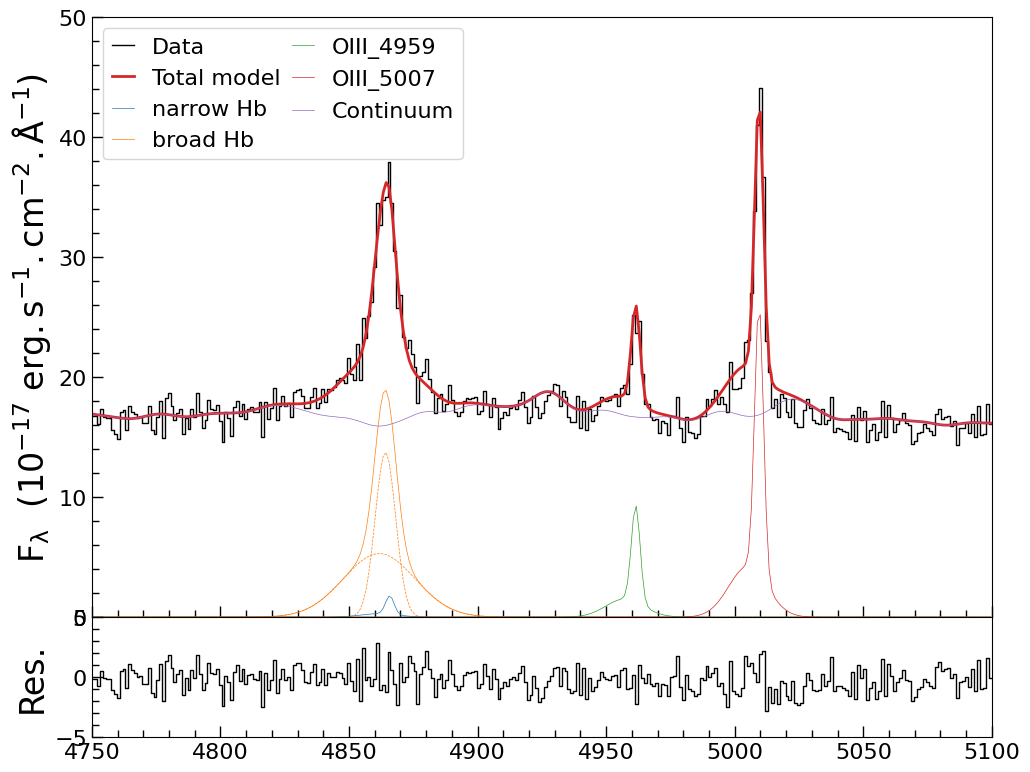

amplitude_0: 1.7726747095409525
dv_0: 121.88849852906009
amp_c_1: 5.293793000081229
dv_c_1: 23.11745187465627
sigma_c_1: 858.1493558101977
amp_w0_1: 2.5953910040077237
dv_w0_1: 150.80820097995738
sigma_w0_1: 246.0226968749971
amplitude_3: 26.16531740170287


In [18]:
def m_init_Hb(velc_tmpl, flux_tmpl, m_fit_cont):
    wave_dict = sagan.utils.line_wave_dict
    label_dict = sagan.utils.line_label_dict
    
    n_hb      = sagan.Line_template(template_velc=velc_tmpl, template_flux=flux_tmpl, amplitude=5, 
                                    dv=0,wavec=wave_dict['Hbeta'], name=f'narrow Hb',fixed={'wavec': True, 'dv': True})
    OIII_5007 = sagan.Line_template(template_velc=velc_tmpl, template_flux=flux_tmpl, amplitude=3, 
                                    dv=0,wavec=wave_dict['OIII_5007'], name=f'OIII_5007', fixed={'wavec': True, 'dv': True})
    OIII_4959 = sagan.Line_template(template_velc=velc_tmpl, template_flux=flux_tmpl, amplitude=3, 
                                    dv=0,wavec=wave_dict['OIII_4959'], name=f'OIII_4959', fixed={'wavec': True, 'dv': True})
    
    b_hb = sagan.Line_MultiGauss(n_components=2, amp_c=1, dv_c=280, sigma_c=200,
                                amp_w0=0.1, dv_w0=0, sigma_w0=50,
                                wavec=wave_dict['Hbeta'],
                                name=f'broad Hb')
    
    def tie_o3(model):
        return model['OIII_5007'].amplitude / 2.98
    OIII_4959.amplitude.tied = tie_o3
    
    line_hb   = n_hb+b_hb
    line_OIII = OIII_4959+OIII_5007
    def m_fit_cont_func(x):
        return m_fit_cont(x)
    cont = sagan.TierContinuum(y_func=m_fit_cont_func, amplitude=1.0, name=f'Continuum')
    cont.amplitude.fixed = True
    
    m_init = line_hb+ line_OIII + cont
    return m_init

m_init = m_init_Hb(velc_OIII_tmpl, flux_OIII_tmpl, m_fit_cont)
ins = ((wave_use>4750)&(wave_use<5100))
weights = 1/ferr**2

mcmc = sagan.MCMC_Fit(m_init,wave_use[ins], flux_use[ins], ferr[ins], nwalkers=70, nsteps=15000)
samples,  m_fit_Hb, param_names = mcmc.fit()

ax, axr = sagan.plot.plot_fit(wave_use[ins], flux_use[ins], m_fit_Hb, weight=weights[ins])
ax.set_xlim(4750,5100)
ax.set_ylim(0,50)
axr.set_ylim(-5, 5)
ax.set_ylabel(r'$\rm {F_\lambda\ \ (10^{-17} \ erg.s^{-1}.cm^{-2}.{\AA}^{-1})}$', fontsize=24)
plt.show()

param_names = sagan.get_free_params(m_fit_Hb)

for param_name in param_names:
    param_value = getattr(m_fit_Hb, param_name).value 
    print(f'{param_name}: {param_value}')

    

#fitter = fitting.TRFLSQFitter(calc_uncertainties=True)
#m_fit_Hb = fitter(m_init, wave_use[ins], flux_use[ins], weights=weights_lines, maxiter=10000)
#ax, axr = sagan.plot.plot_fit(wave_use, flux_use, m_fit_Hb, weight=weights)
#ax.set_ylabel(r'$\rm {F_\lambda\ \ (10^{-17} \ erg.s^{-1}.cm^{-2}.{\AA}^{-1})}$', fontsize=24)
#ax.set_xlim(4750,5100)
#ax.set_ylim(0,50)
#axr.set_ylim(-5, 5)
#plt.show()

#param_names = get_free_params(m_fit_Hb)
#param_values = fitter.fit_info['x']
#param_cov = fitter.fit_info['param_cov']
#if param_cov is not None:
#    param_errors = np.sqrt(np.diag(param_cov))
#    for name, value, error in zip(param_names, param_values, param_errors):
#        print(f"{name} = {value:.4f}, error: {error:.4f}")